In [2]:
from pathlib import Path


PosixPath('/home/energy/amawi/projects/jdw/denoising_diffusion_flax')

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ['JAX_ENABLE_X64']=True
# os.environ['CUDA_VISIBLE_DEVICES']='0'  # get_gpu 
# os.environ['JAX_ENABLE_X64']='False'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='0.87'
# os.environ['XLA_FLAGS']='--xla_gpu_strict_conv_algorithm_picker=false'
# os.environ['xla_gpu_strict_conv_algorithm_picker']='false'
# os.environ

TypeError: str expected, not bool

In [1]:
os.system('echo $JAX_ENABLE_X64')

0

In [2]:
from ml_collections import config_dict
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import torch
from tqdm import tqdm, trange
import math
import matplotlib.pyplot as plt 
from PIL import Image
import functools

import wandb

import jax
import jax.numpy as jnp
from flax import jax_utils
from flax.training import checkpoints
from einops import rearrange, repeat

import train
import utils

root_directory = 'denoising-diffusion-flax'
example_directory = 'denoising-diffusion-flax/denoising_diffusion_flax'
repo, branch =  'https://github.com/yiyixuxu/denoising-diffusion-flax', 'main'

def to_np(x):
  """Converts TF/JAX tensors to numpy."""
  return np.asarray(x, dtype=np.float32)

def to_wandb_img(img):
    img = rearrange(to_np(img), ' d b h w c -> (d b) c h w')
    if img.shape[1] == 1:
      img = repeat(img, 'b c h w -> b (repeat c) h w', repeat =3)
    return torch.tensor(img)

rng = jax.random.PRNGKey(0)
jax.local_devices()

[StreamExecutorGpuDevice(id=0, process_index=0)]

In [3]:
from configs import fashion_mnist as config_lib
my_config = config_lib.get_config()
my_config

data:
  batch_size: 128
  cache: false
  channels: 1
  dataset: fashion_mnist
  image_size: 28
ddpm:
  beta_schedule: linear
  p2_loss_weight_gamma: 0.0
  p2_loss_weight_k: 1
  pred_x0: false
  self_condition: false
  timesteps: 1000
ema:
  beta: 0.995
  inv_gamma: 1.0
  min_value: 0.0
  power: 0.6666666666666666
  update_after_step: 100
  update_every: 10
model:
  dim: 64
  dim_mults: !!python/tuple
  - 1
  - 2
  - 4
optim:
  beta1: 0.9
  beta2: 0.99
  eps: 1.0e-08
  lr: 0.001
  optimizer: Adam
seed: 42
training:
  half_precision: false
  log_every_steps: 100
  loss_type: l1
  num_sample: 64
  num_train_steps: 12000
  save_and_sample_every: 1000
wandb:
  entity: xmax1
  job_type: training
  log_model: true
  log_sample: true
  log_train: true
  name: demo
  project: jax-ddpm-demo

In [4]:
train_it = train.get_dataset(rng, my_config)
img = next(train_it)['image']

wandb.Image(to_wandb_img(img)).image

train.apply_ema_decay??

Signature: train.apply_ema_decay(state, ema_decay)
Docstring: <no docstring>
Source:   
def apply_ema_decay(state, ema_decay):
    params_ema = jax.tree_map(lambda p_ema, p: p_ema * ema_decay + p * (1. - ema_decay), state.params_ema, state.params)
    state = state.replace(params_ema = params_ema)
    return state
File:      ~/projects/denoising-diffusion-flax/denoising_diffusion_flax/train.py
Type:      function


In [5]:
work_dir = './fashion_mnist'
state = train.train(my_config, work_dir)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xmax1. Use `wandb login --relogin` to force relogin


/home/amawi/.conda/envs/dex/lib/python3.10/site-packages/jax/linear_util.py:168: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in linspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))
/home/amawi/.conda/envs/dex/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2192: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/amawi/.conda/envs/dex/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2193: UserW

XlaRuntimeError: UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.5 = (f32[128,28,28,384]{2,1,3,0}, u8[0]{0}) custom-call(f32[128,28,28,64]{2,1,3,0} %multiply.2456, f32[1,1,64,384]{1,0,2,3} %copy.6), window={size=1x1}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convForward", metadata={op_name="pmap(<unnamed wrapped function>)/jit(main)/jvp(Unet)/down_0.attnblock_0/LinearAttention_0/to_qkv.conv_0/conv_general_dilated[window_strides=(1, 1) padding=((0, 0), (0, 0)) lhs_dilation=(1, 1) rhs_dilation=(1, 1) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)) feature_group_count=1 batch_group_count=1 lhs_shape=(128, 28, 28, 64) rhs_shape=(1, 1, 64, 384) precision=None preferred_element_type=None]" source_file="/home/amawi/.conda/envs/dex/lib/python3.10/site-packages/flax/linen/linear.py" source_line=375}, backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"

Original error: INTERNAL: All algorithms tried for %cudnn-conv.5 = (f32[128,28,28,384]{2,1,3,0}, u8[0]{0}) custom-call(f32[128,28,28,64]{2,1,3,0} %multiply.2456, f32[1,1,64,384]{1,0,2,3} %copy.6), window={size=1x1}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convForward", metadata={op_name="pmap(<unnamed wrapped function>)/jit(main)/jvp(Unet)/down_0.attnblock_0/LinearAttention_0/to_qkv.conv_0/conv_general_dilated[window_strides=(1, 1) padding=((0, 0), (0, 0)) lhs_dilation=(1, 1) rhs_dilation=(1, 1) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)) feature_group_count=1 batch_group_count=1 lhs_shape=(128, 28, 28, 64) rhs_shape=(1, 1, 64, 384) precision=None preferred_element_type=None]" source_file="/home/amawi/.conda/envs/dex/lib/python3.10/site-packages/flax/linen/linear.py" source_line=375}, backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}" failed. Falling back to default algorithm.  Per-algorithm errors:
  Profiling failure on cuDNN engine eng34{k2=0,k4=1,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng34{k2=1,k4=2,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng34{k2=2,k4=1,k5=1,k6=0,k7=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng28{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng1{k2=4,k3=0}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng2{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng3{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng4{}: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng28{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng34{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on cuDNN engine eng42{}: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.

In [ ]:
jax.__version_info__

(0, 3, 23)

In [15]:
sample_dir = work_dir + '/samples'
os.listdir(sample_dir)

['iter_4999_host_0',
 'iter_9999_host_0',
 'iter_14999_host_0',
 'iter_19999_host_0']

In [16]:
# find the most recent generated samples
iter_last = max([int(f.split('_')[1]) for f in os.listdir(sample_dir)])
sample_path = sample_dir + '/iter_' + str(iter_last) +  '_host_0/sample.png'
sample_path

'./flower102/samples/iter_19999_host_0/sample.png'

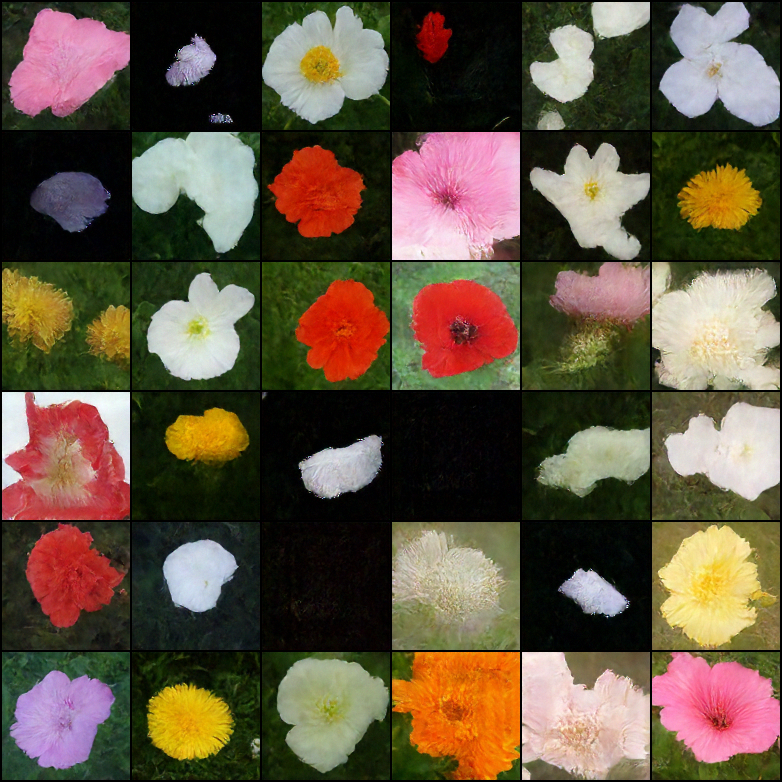

In [17]:
Image.open(sample_path)

## sampling from a pre-trained model 

the pre-trained model we are using is trained with both self-conditioning and p2 weighting for 300k steps 


In [26]:
from sampling import sample_loop, ddpm_sample_step, model_predict
from configs import oxford102_p2_selfcondition

In [34]:
# feel free to choose a different seed
sample_seed = 0
num_sample = 64
wandb_artifact = 'yiyixu/ddpm-flax-flower102/model-38gwgt6w:v0'
sample_bs = 16 # 

In [35]:
cfg = oxford102_p2_selfcondition.get_config()

In [36]:
shape = (jax.device_count(), 
         sample_bs, 
         cfg.data.image_size, 
         cfg.data.image_size, 
         cfg.data.channels)
shape

(1, 16, 128, 128, 3)

In [37]:
rng = jax.random.PRNGKey(sample_seed)
rng, state_rng = jax.random.split(rng)

state = train.create_train_state(state_rng, cfg)
run = wandb.init()
artifact = run.use_artifact('yiyixu/ddpm-flax-flower102/model-38gwgt6w:v0', type='ddpm_model')
artifact_dir = artifact.download()

state = checkpoints.restore_checkpoint(artifact_dir, state)
state = jax_utils.replicate(state)

ddpm_params = utils.get_ddpm_params(cfg.ddpm)

sample_step = functools.partial(ddpm_sample_step, ddpm_params=ddpm_params, self_condition=cfg.ddpm.self_condition, is_pred_x0=cfg.ddpm.pred_x0)
p_sample_step = jax.pmap(sample_step, axis_name='batch')



wandb: Downloading large artifact model-38gwgt6w:v0, 553.34MB. 1 files... Done. 0:0:1.9


generating samples


100%|██████████| 1/1 [00:46<00:00, 46.65s/it]


In [41]:
print("generating samples")
samples = []
for i in trange(0, num_sample, sample_bs):
  rng, sample_rng = jax.random.split(rng)
  samples.append(sample_loop(sample_rng, state, shape, p_sample_step, cfg.ddpm.timesteps))

samples = jnp.concatenate(samples) # num_devices, batch, H, W, C
          

generating samples


100%|██████████| 4/4 [02:27<00:00, 36.93s/it]


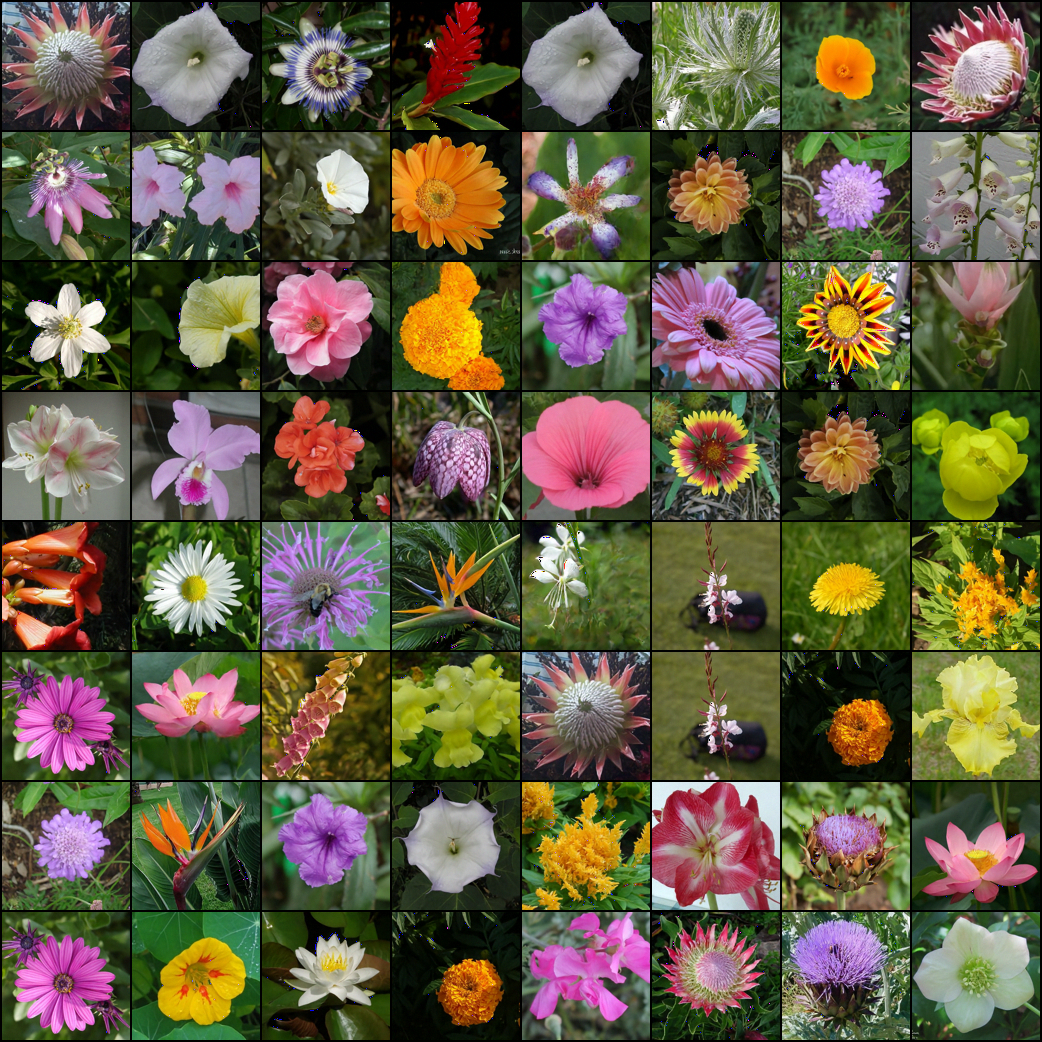

In [42]:
wandb.Image(to_wandb_img(samples)).image